Load All the Initial Python Modules
 - mm_astra (multi-modal with astra backend) is the core component that performs the GPU-tomography reconstuctions

In [1]:
import Utils.mm_astra as mm_astra
import Utils.utils_cs_eds as utils
import Utils.pytvlib as pytvlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import h5py

In [2]:
# Auxilary Function to Visualize Slices of the Phantom Object or Reconstruction
def display_recon_slices(slice, delta):                                                                         
    fig, ax = plt.subplots(1,4,figsize=(12,20))
    ax = ax.flatten()

    for i in range(len(elements)):
        ax[i].imshow(np.mean(reconTotal[i,:,slice-int(delta/2):slice+int(delta/2),:],axis=1),cmap='gray'); 
        ax[i].set_title(elements[i]+': '+str(np.min(reconTotal[i,]))+' '+str(np.max(reconTotal[i,]))); ax[i].axis('off')

#### Reading Multi-Modal Chemical Tilt Series Data

Let's read the chemical tilt series from the Au-Fe $_3$ O $_4$ dataset. The EELS chemical maps are already pre-processed and aligned with the [projection matching method](https://github.com/jtschwar/projection_refinement). We can use mm_astra to handle the chemical dataset as a single variable to easily create reconstructions with conventional and state-of-the-art algorithms

In [3]:
# Load Data
fname = '/home/zzhang/OneDrive/workshop/Multi_Modal_Data_Fusion_Chemical_Tomography/Au_Fe3O4/Cubic_Structure_Figure1/Tilt_Series/cubic_Au_Fe3O4_aligned.h5'
inFiles = h5py.File(fname,'r')
haadf = inFiles['haadf/tiltSeries'][:]
haadf[haadf<0] = 0
Au = inFiles['eels/Au'][:]; Au[Au<0] = 0; 
Fe = inFiles['eels/Fe'][:]; Fe[Fe<0] = 0
C = inFiles['eels/C'][:]; C[C<0] = 0;  
O = inFiles['eels/O'][:]; O[O<0] = 0   

# normalize tilt series
Au /= np.max(Au); C /= np.max(C);
Fe /= np.max(Fe); O /= np.max(O);

# read tilt angles
haadfTiltAngles = inFiles['haadf/tiltAngles'][:]
NprojHAADF = haadfTiltAngles.shape[0]

chemTiltAngles  = inFiles['eels/tiltAngles'][:]
NprojCHEM = chemTiltAngles.shape[0]

inFiles.close()

# Auxiliary variables
gamma = 1.6
zNum = np.array([79,26,6,8], dtype=int)
elements = ['Au', 'Fe', 'C', 'O']
(nx, ny, _) = haadf.shape
nPix = nx * ny
nz = len(elements)

(-0.5, 179.5, 179.5, -0.5)

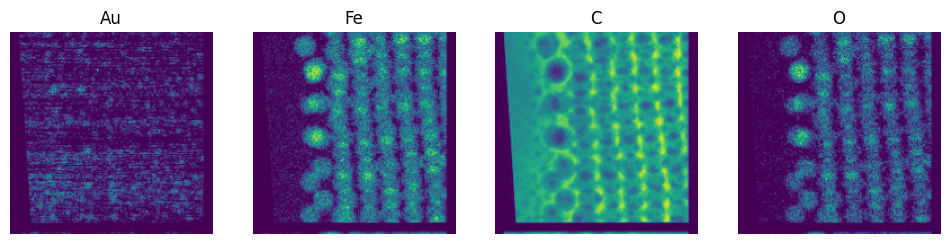

In [4]:
fig, ax = plt.subplots(1,4,figsize=(12,20))
ax = ax.flatten()

ax[0].imshow(Au[:,:,1]); ax[0].set_title('Au'); ax[0].axis('off')
ax[1].imshow(Fe[:,:,1]); ax[1].set_title('Fe'); ax[1].axis('off')
ax[2].imshow(C[:,:,1]); ax[2].set_title('C'); ax[2].axis('off')
ax[3].imshow(O[:,:,1]); ax[3].set_title('O'); ax[3].axis('off')


In [5]:
# Initialize Tomography Operator
tomo = mm_astra.mm_astra(nx,ny,nz, np.deg2rad(haadfTiltAngles), np.deg2rad(chemTiltAngles))

# Pass HAADF Projections
bh = np.zeros([nx,ny*NprojHAADF])
for s in range(nx):
    bh[s,] = haadf[s,].transpose().flatten()
tomo.set_haadf_tilt_series(bh)

# Pass Chemical Projections
bChem = np.zeros([nx,nx*NprojCHEM*nz],dtype=Au.dtype)
for ss in range(nx):
    bChem[ss,] = np.concatenate([Au[ss,].T.flatten(), Fe[ss,].T.flatten(), C[ss,].T.flatten(), O[ss,].T.flatten()])
tomo.set_chem_tilt_series(bChem)

# define gamma 
tomo.set_gamma(gamma)

# Create Summation Matrix
sigmaMethod = 3
sigma = utils.create_weighted_summation_matrix(nx, nx, nz, zNum, 1.6,sigmaMethod)
(rows, cols) = sigma.nonzero(); vals = sigma.data
sigma = np.array([rows,cols,vals],dtype=np.float32,order='C')
tomo.load_sigma(sigma)

# Initialize Projection Operators
tomo.initialize_FP(); tomo.initialize_BP(); tomo.initialize_SIRT()

# Estimate Lipschitz
tomo.estimate_lipschitz()

# Bool for Measuring Cost Function
tomo.set_measureChem(True); tomo.set_measureHaadf(True)

reconTotal = np.zeros([nz,nx,ny,ny],dtype=np.float32)

Setting Gamma to: 1.6


#### Chemical Tomography with the Raw Data (Non-Fused Reconstructions)

Let's start off with using the Poisson Maximum Likelihood (Poisson-ML) algorithm.

$\hat{\bm{x}} = \arg \min_{\bm{x} \geq 0} ~ b_{\text{chem}} \log [ \bm{Ax}_i ] - \bm{Ax}_i $ 

100%|██████████| 250/250 [01:45<00:00,  2.37it/s]


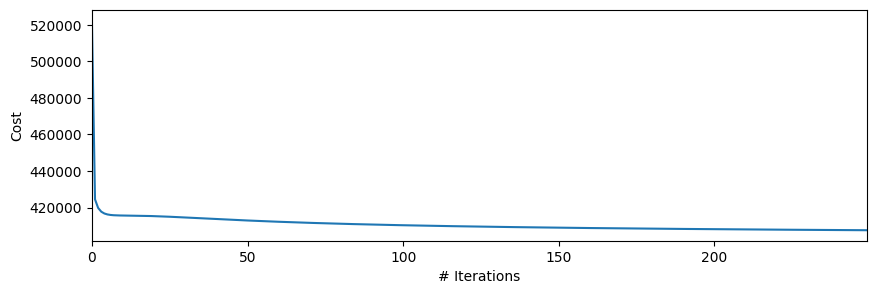

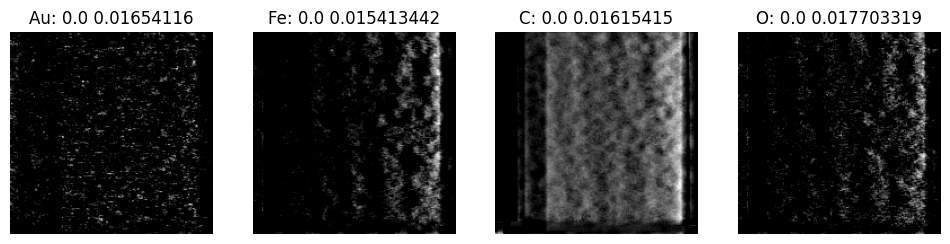

In [6]:
tomo.restart_recon()

Niter = 250
costCHEM = np.zeros(Niter)
for ii in tqdm(range(Niter)):
    costCHEM[ii] = tomo.poisson_ml(0.05)

plt.figure(figsize=(10,3)); plt.plot(costCHEM)
plt.xlim([0,Niter-1]); plt.xlabel('# Iterations'); plt.ylabel('Cost')
    
for e in range(nz):
    for s in range(nx):
        reconTotal[e,s,] = tomo.get_recon(e,s)
display_recon_slices(128,2)

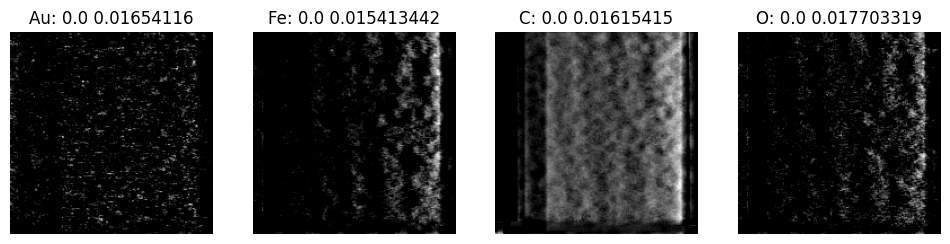

In [46]:
display_recon_slices(128,2)

Now let's continue with the SIRT algorithm.

$\hat{\bm{x}} = \arg \min_{\bm{x} \geq 0} \frac{1}{2} \| \bm{Ax} - b_{\text{chem}} \|_{2}^{2} $ 

100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


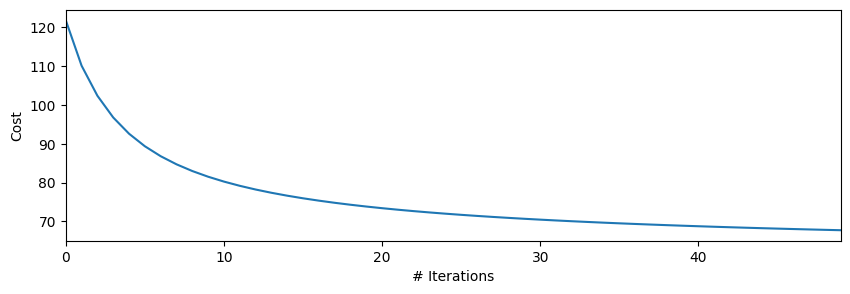

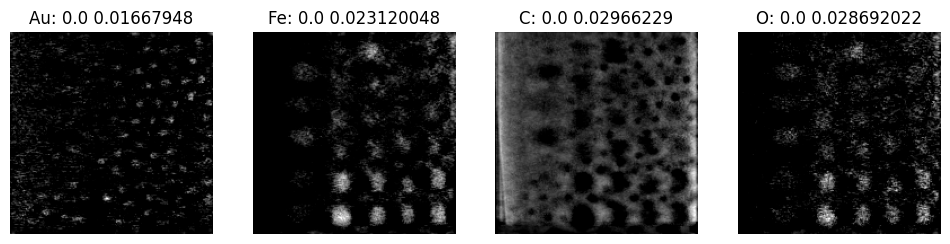

In [7]:
tomo.restart_recon()

Niter = 50
costCHEM = np.zeros(Niter)
for i in tqdm(range(Niter)):
    tomo.chemical_SIRT(1)
    costCHEM[i] = tomo.data_distance()

plt.figure(figsize=(10,3)); plt.plot(costCHEM)
plt.xlim([0,Niter-1]); plt.xlabel('# Iterations'); plt.ylabel('Cost')

for e in range(nz):
    for s in range(nx):
        reconTotal[e,s,] = tomo.get_recon(e,s)
display_recon_slices(95,2)

Now let's wrap it up with the SART

$\hat{\bm{x}} = \arg \min_{\bm{x} \geq 0} \| \bm{Ax} - b_{\text{chem}} \|_{2}^{2} $ 

ProjectionOrder: sequential


100%|██████████| 15/15 [01:20<00:00,  5.37s/it]


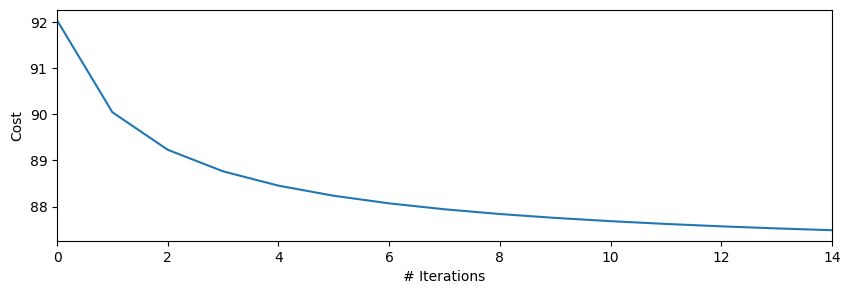

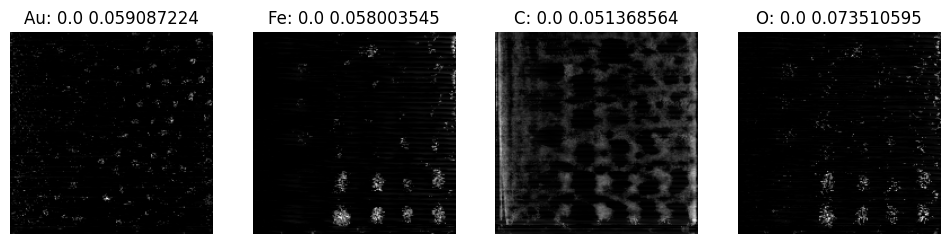

In [8]:
tomo.restart_recon()
tomo.initialize_SART('sequential')

Niter = 15
costCHEM = np.zeros(Niter)
for i in tqdm(range(Niter)):
    tomo.chemical_SART(1)
    costCHEM[i] = tomo.data_distance()
    
plt.figure(figsize=(10,3)); plt.plot(costCHEM)
plt.xlim([0,Niter-1]); plt.xlabel('# Iterations'); plt.ylabel('Cost')

for e in range(nz):
    for s in range(nx):
        reconTotal[e,s,] = tomo.get_recon(e,s)
display_recon_slices(95,2)

We can save our preliminary reconstructions using the following utility function: 

In [11]:
import os
# os.remove('Output_recon/raw_recon.h5')
os.makedirs('Output_recon',exist_ok=True)
utils.save_h5('Output_recon','raw_recon',Au=reconTotal[0,],Fe=reconTotal[1,],C=reconTotal[2,],O=reconTotal[3,])

('raw_recon',)
Au
Fe
C
O


Now we can reload those preliminary states whenever we would like. 

In [12]:
def reload_starting_volume():
    scale = 10

    reconTotal = np.zeros([nz,nx,ny,ny],dtype=np.float32)
    f = h5py.File('Output_recon/raw_recon.h5','r')

    # parse reconstruction for h5 file
    eInd = 0
    for e in elements:
        reconTotal[eInd,] = np.array(f[e])
        eInd += 1
    f.close()
    reconTotal *= scale

    # pass reconstructions to C++ reconstructor
    for e in range(nz):
        for s in range(nx):
            tomo.set_recon(reconTotal[e,s,],e,s)

    # recale projections
    tomo.rescale_projections()

#### Data Fusion 

Now that we have completed preprocess and reconctructing the initial data, we can focus on solving the following cost function:

$ \hat{\bm{x}} = \arg \min_{\bm{x}\geq 0} \frac{1}{2} \| \bm{A} \Sigma_i $

For more details, please refer to our pre-print manuscript available on arXiv: 

100%|██████████| 50/50 [01:38<00:00,  1.96s/it]


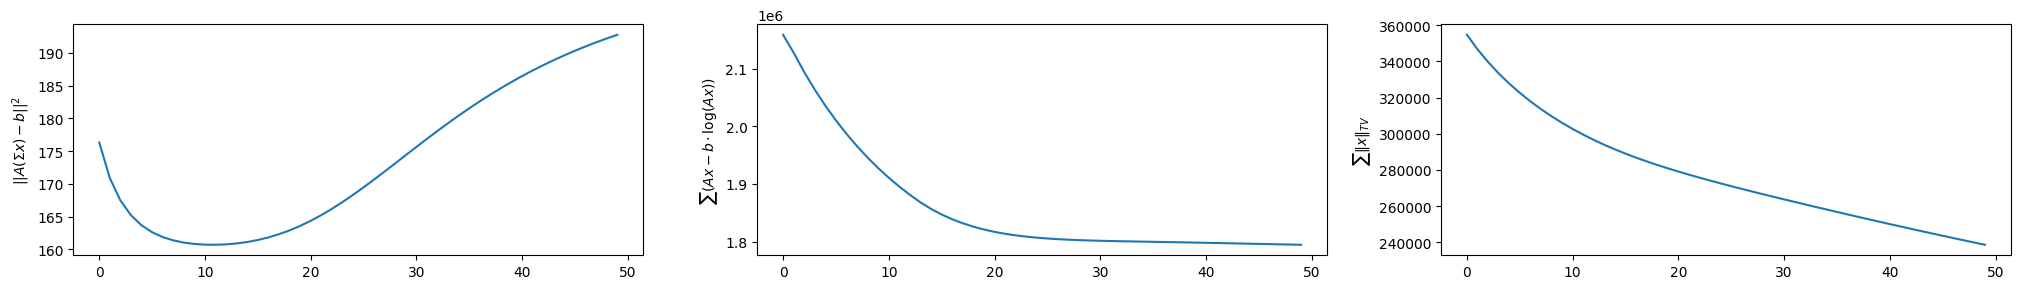

In [13]:
reload_starting_volume()

# reconsturction parameters
reduceLambda = True

Niter = 50; tvIter = 5; iterSIRT = 5
lambdaTV = 0.0001; lambdaCHEM = 0.05; lambdaHAADF = 10

# store parameters
costCHEM = np.zeros(Niter, dtype=np.float32)
costHAADF = costCHEM.copy(); costTV = costCHEM.copy()
params = {'lambdaTV':lambdaTV, 'tvIter':tvIter, 'Niter':Niter, 'gamma': gamma,
          'lambdaCHEM':lambdaCHEM, 'lambdaHAADF':lambdaHAADF, 'iterSIRT':iterSIRT,
          'sigmaMethod':sigmaMethod, 'reduceLambda':reduceLambda}

# main loop
for i in tqdm(range(Niter)):
    (costHAADF[i], costCHEM[i]) = tomo.sirt_data_fusion(lambdaHAADF,lambdaCHEM,iterSIRT)
    costTV[i] = tomo.tv_fgp_4D(tvIter,lambdaTV)
    if i > 0 and costHAADF[i] > costHAADF[i-1]: lambdaCHEM *= 0.95

# return recon to python
for e in range(nz):
    for s in range(nx):
        reconTotal[e,s,] = tomo.get_recon(e,s)

# show cost function
plt.figure(figsize=(25,3))

ax1 = plt.subplot(1,3,1); ax1.set_ylabel(r'$||A (\Sigma x) - b||^2$')
ax2 = plt.subplot(1,3,2); ax2.set_ylabel(r'$\sum (Ax - b \cdot \log(Ax))$')
ax3 = plt.subplot(1,3,3); ax3.set_ylabel(r'$\sum \|x\|_{TV}$')
ax1.plot(costHAADF); ax2.plot(costCHEM); ax3.plot(costTV)

Above is the decay for the three components of the cost function, 
we can also look at 2D slices of our chemical reconstructions and the HAADF reprojection based on our forward model. 

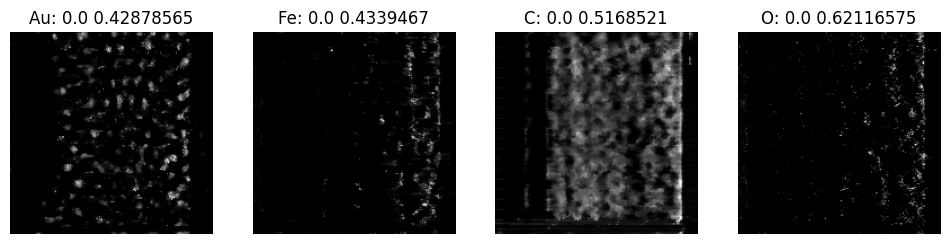

In [14]:
display_recon_slices(128,2)

Text(0.5, 1.0, 'Reprojection: 1.43')

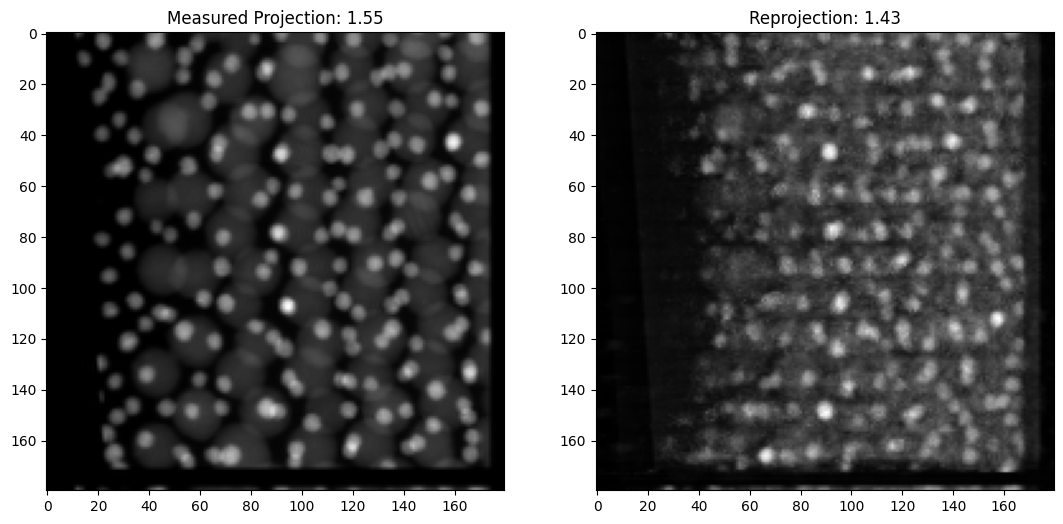

In [15]:
g = tomo.get_model_projections()
bhTemp = tomo.get_haadf_projections()

ind = 10

plt.figure(figsize=(13,13))
ax1 = plt.subplot(1,2,1); ax1.imshow(bhTemp[:,ny*ind:ny*(ind+1)],cmap='gray'); ax1.set_title('Measured Projection: '+str(np.round(np.max(bhTemp[:,:256]),2)))
ax2 = plt.subplot(1,2,2); ax2.imshow(g[:,ny*ind:ny*(ind+1)],cmap='gray'); ax2.set_title('Reprojection: '+str(np.round(np.max(g[:,:256]),2)))